# Import backage

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from models_new import Renorm_Dynamic
from dynamic_models_sis_new import Simple_Spring_Model
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Five parallel experiments

In [3]:
# try without init part sample
experiments = 5
mul_batch_size = [0,10,4500,1500]
#mul_batch_size = [0,5000,3000,1000]
sigma = 0.03
rou = -0.5
steps = 7
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 30001
dt = 0.01

eis_nis_e = np.zeros([experiments,T_total//500+1])
losses_nis_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nis_e = np.zeros([experiments,T_total//500+1])
eis_nisp_e = np.zeros([experiments,T_total//500+1])
losses_nisp_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nisp_e = np.zeros([experiments,T_total//500+1])

In [4]:
# nis
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis, net_nis= train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis')
    eis_nis_e[e,:] = eis_nis
    losses_nis_e[e,:] = losses_nis
    MAEs_mstep_nis_e[e,:] = MAEs_mstep_nis

check point-------o_0-> 14:26:51.438034; lasting 0:00:51.167474 seconds
Epoch: 0
Train loss: 0.5174
dEI: 0.3344
term1: -0.7183
term2: 1.3871
Test multistep loss: 0.6344
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:26:56.814418; lasting 0:00:05.376384 seconds
Train loss: 0.0306
dEI: 2.0872
term1: 2.5210
term2: 1.6533
Test multistep loss: 0.0525
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:29:14.091466; lasting 0:00:14.780505 seconds
check point-------o_0-> 14:29:23.071734; lasting 0:00:08.980268 seconds
Epoch: 3500
Train loss: 0.0288
dEI: 2.1305
term1: 2.6138
term2: 1.6472
Test multistep loss: 0.0403
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:29:36.693432; lasting 0:00:13.621698 se

In [ ]:
# nis+
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net_nisp = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis+')
    eis_nisp_e[e,:] = eis_nisp
    losses_nisp_e[e,:] = losses_nisp
    MAEs_mstep_nisp_e[e,:] = MAEs_mstep_nisp

check point-------o_0-> 16:10:11.122329; lasting 0:00:03.949490 seconds
Epoch: 0
Train loss: 0.5174
dEI: 0.3344
term1: -0.7183
term2: 1.3871
Test multistep loss: 0.6005
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:10:15.623707; lasting 0:00:04.501378 seconds
check point-------o_0-> 16:10:30.042834; lasting 0:00:14.419127 seconds
Epoch: 500
Train loss: 0.0780
dEI: 1.3220
term1: 0.9891
term2: 1.6548
Test multistep loss: 0.1014
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:10:36.564390; lasting 0:00:06.521556 seconds
check point-------w_0-> 16:10:51.687320; lasting 0:00:15.122930 seconds
check point-------w_1-> 16:10:51.704770; lasting 0:00:00.017450 seconds
check point-------w_2-> 16:13:40.366365; lasting 0:02:48.661595 seconds
check point-------w_3-> 16:13:40.416750; lasting 0:00:00.05

# Plot

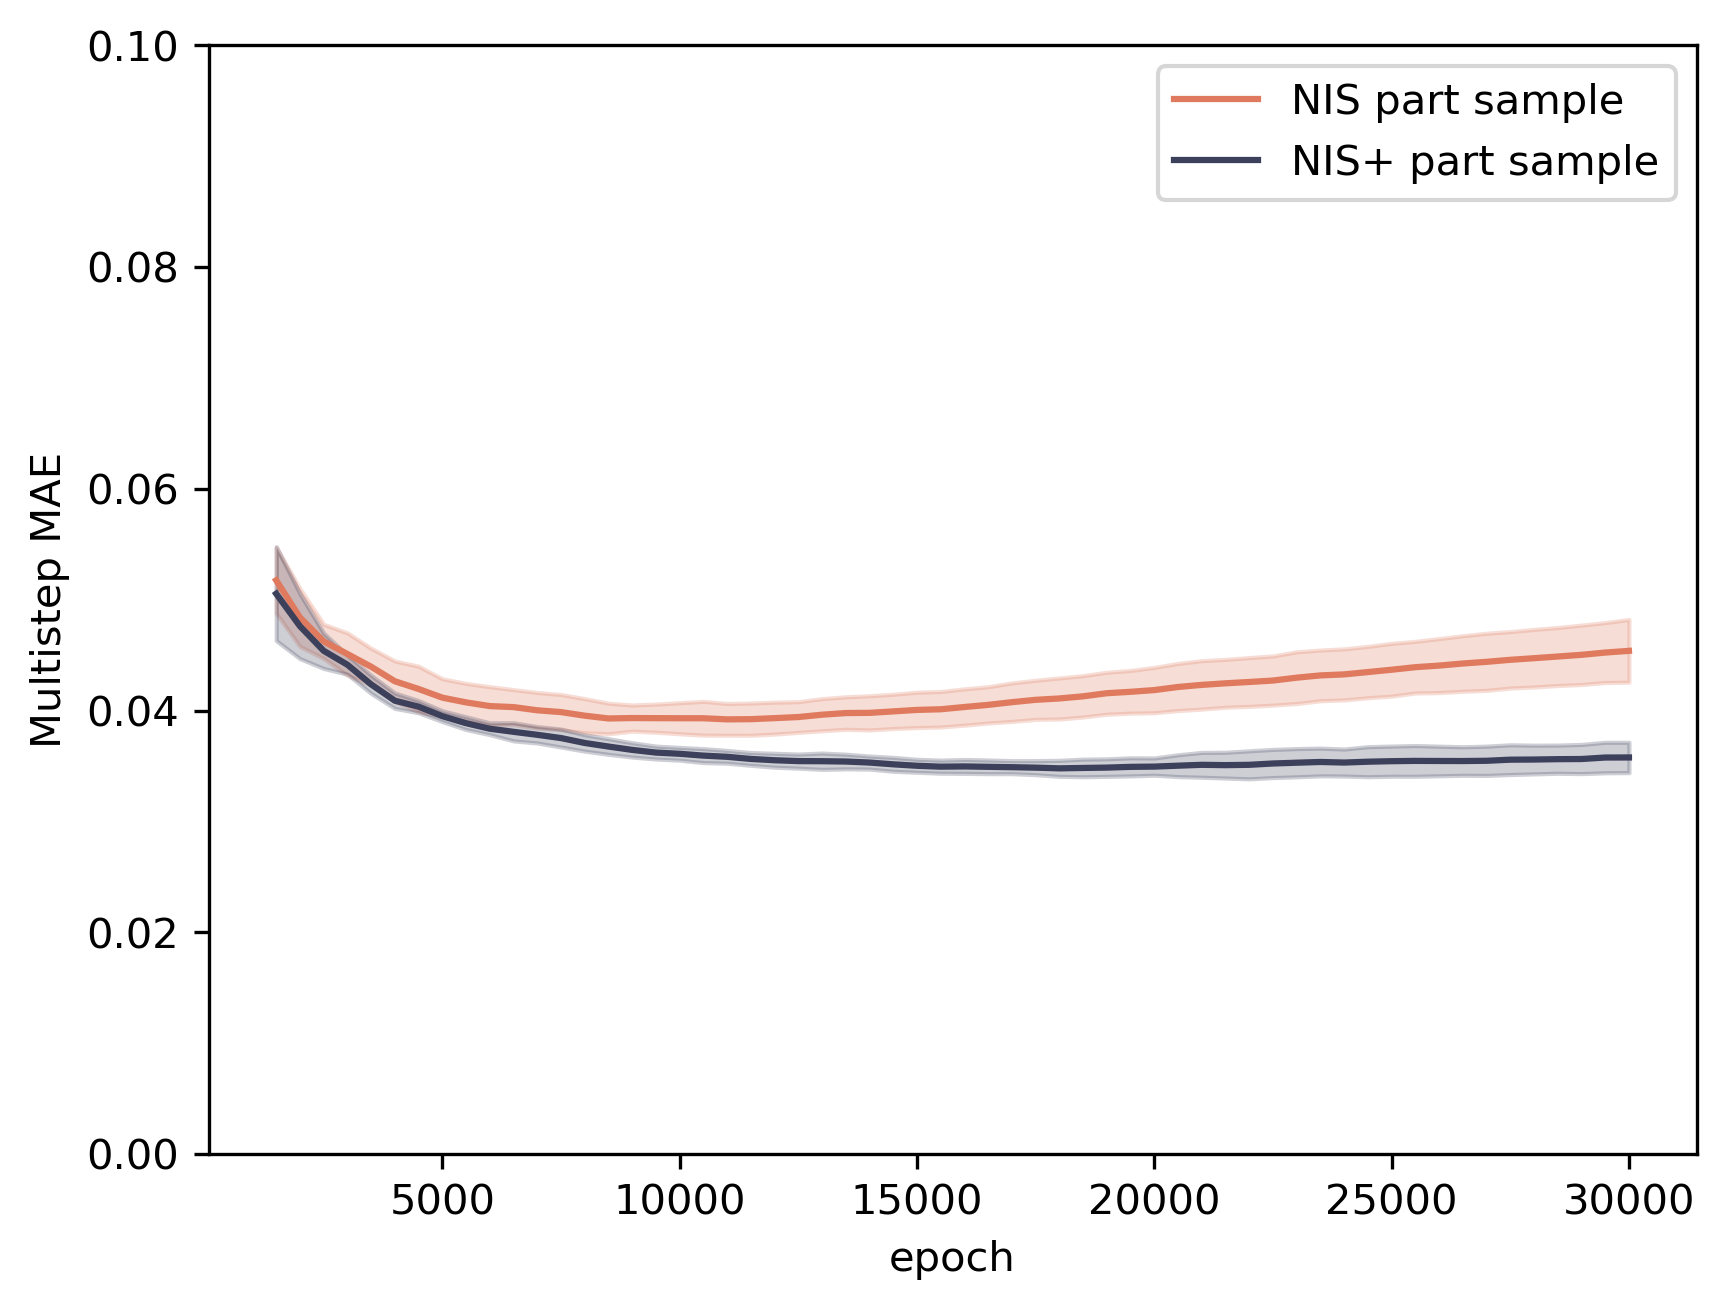

In [11]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
lens=len(MAEs_mstep_nis_e[0,3:])
timesteps = np.arange(len(MAEs_mstep_nis_e[0,:]))[3:]*500
compare1=np.cumsum(MAEs_mstep_nis_e[:,3:],1)/np.linspace(1, lens, lens)
compare2=np.cumsum(MAEs_mstep_nisp_e[:,3:],1)/np.linspace(1, lens, lens)
means_nis = np.mean(compare1,axis=0)
stds_nis = np.std(compare1,axis=0)
means_nisp = np.mean(compare2,axis=0)
stds_nisp = np.std(compare2,axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel('Multistep MAE')
plt.ylim([0,0.1])
plt.show()

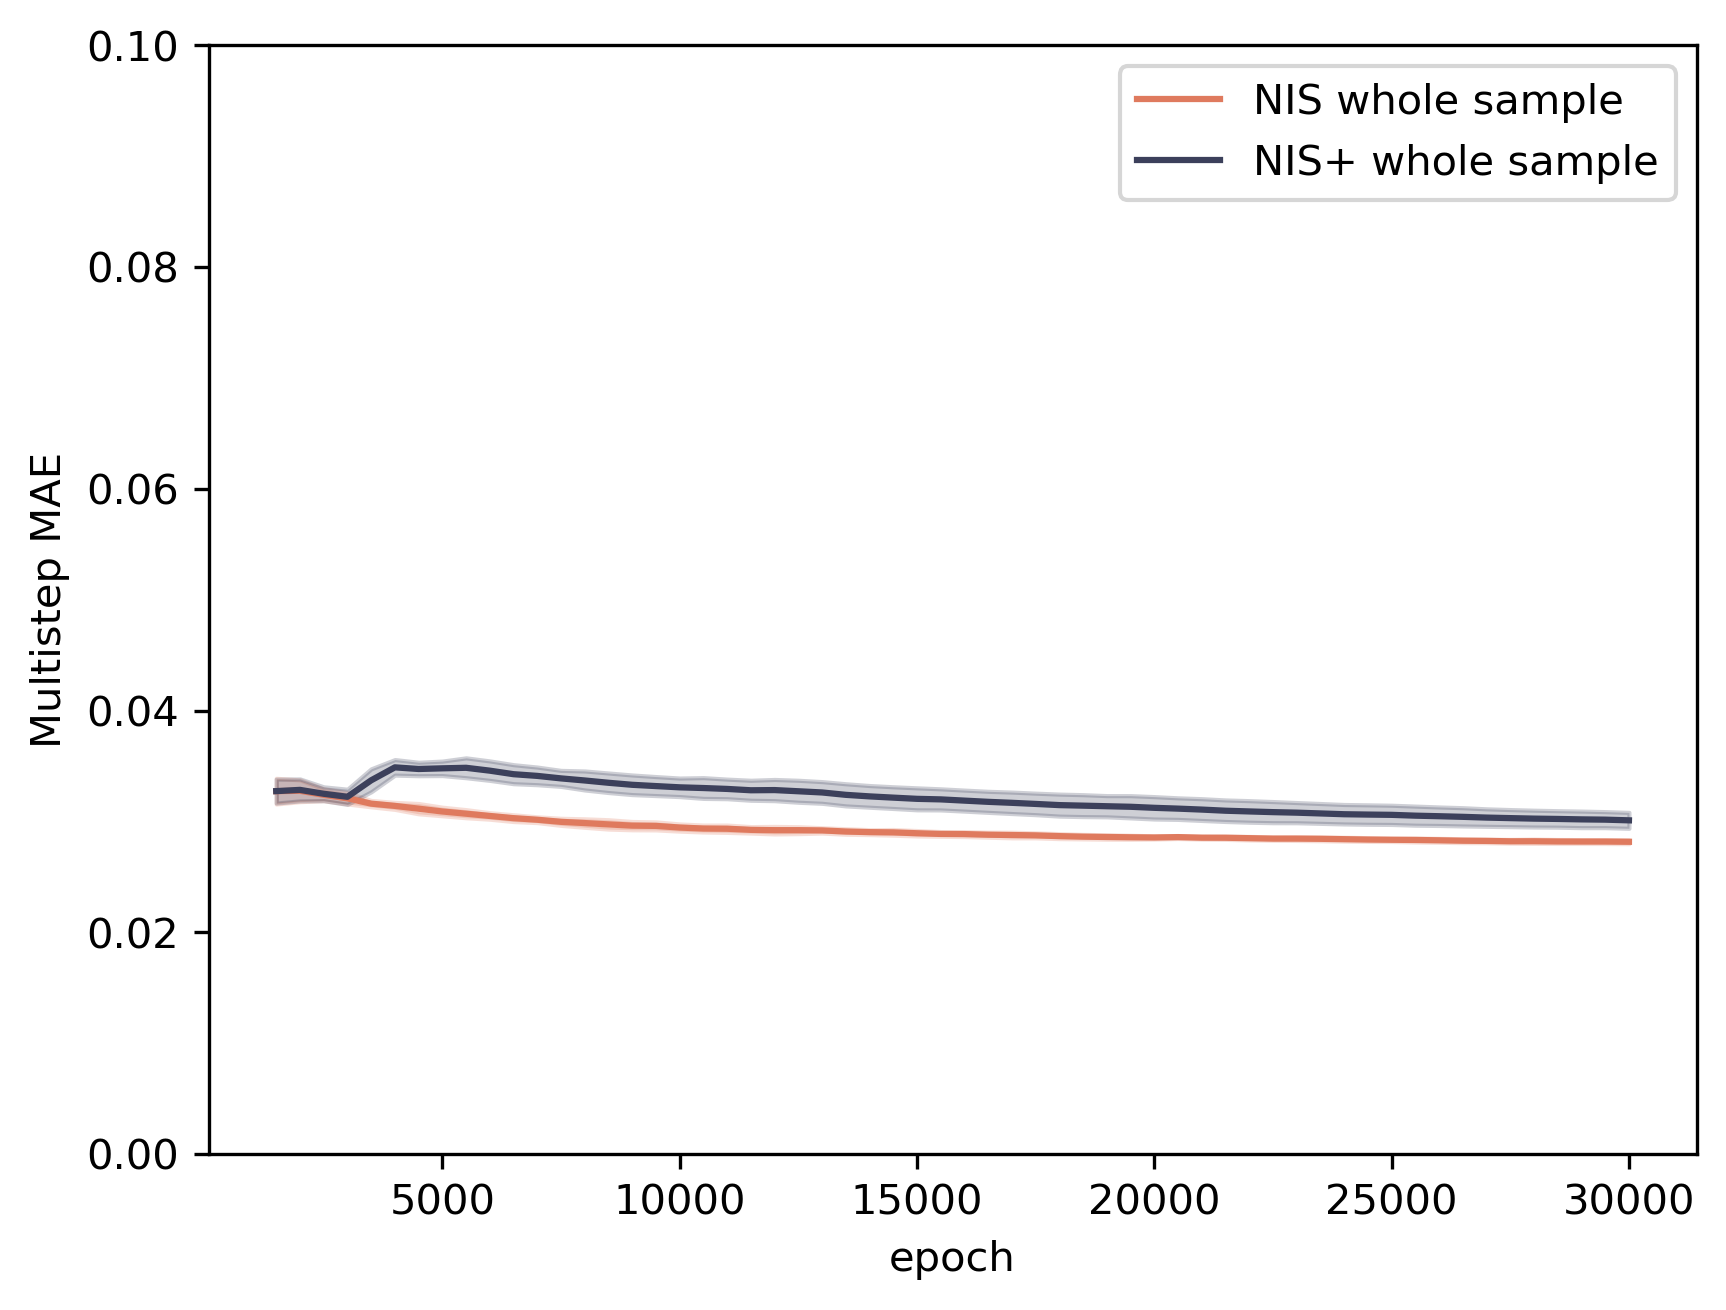

In [6]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
lens=len(MAEs_mstep_nis_e[0,3:])
timesteps = np.arange(len(MAEs_mstep_nis_e[0,:]))[3:]*500
compare1=np.cumsum(MAEs_mstep_nis_e[:,3:],1)/np.linspace(1, lens, lens)
compare2=np.cumsum(MAEs_mstep_nisp_e[:,3:],1)/np.linspace(1, lens, lens)
means_nis = np.mean(compare1,axis=0)
stds_nis = np.std(compare1,axis=0)
means_nisp = np.mean(compare2,axis=0)
stds_nisp = np.std(compare2,axis=0)
plt.plot(timesteps, means_nis, label='NIS whole sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ whole sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel('Multistep MAE')
plt.ylim([0,0.1])
plt.show()

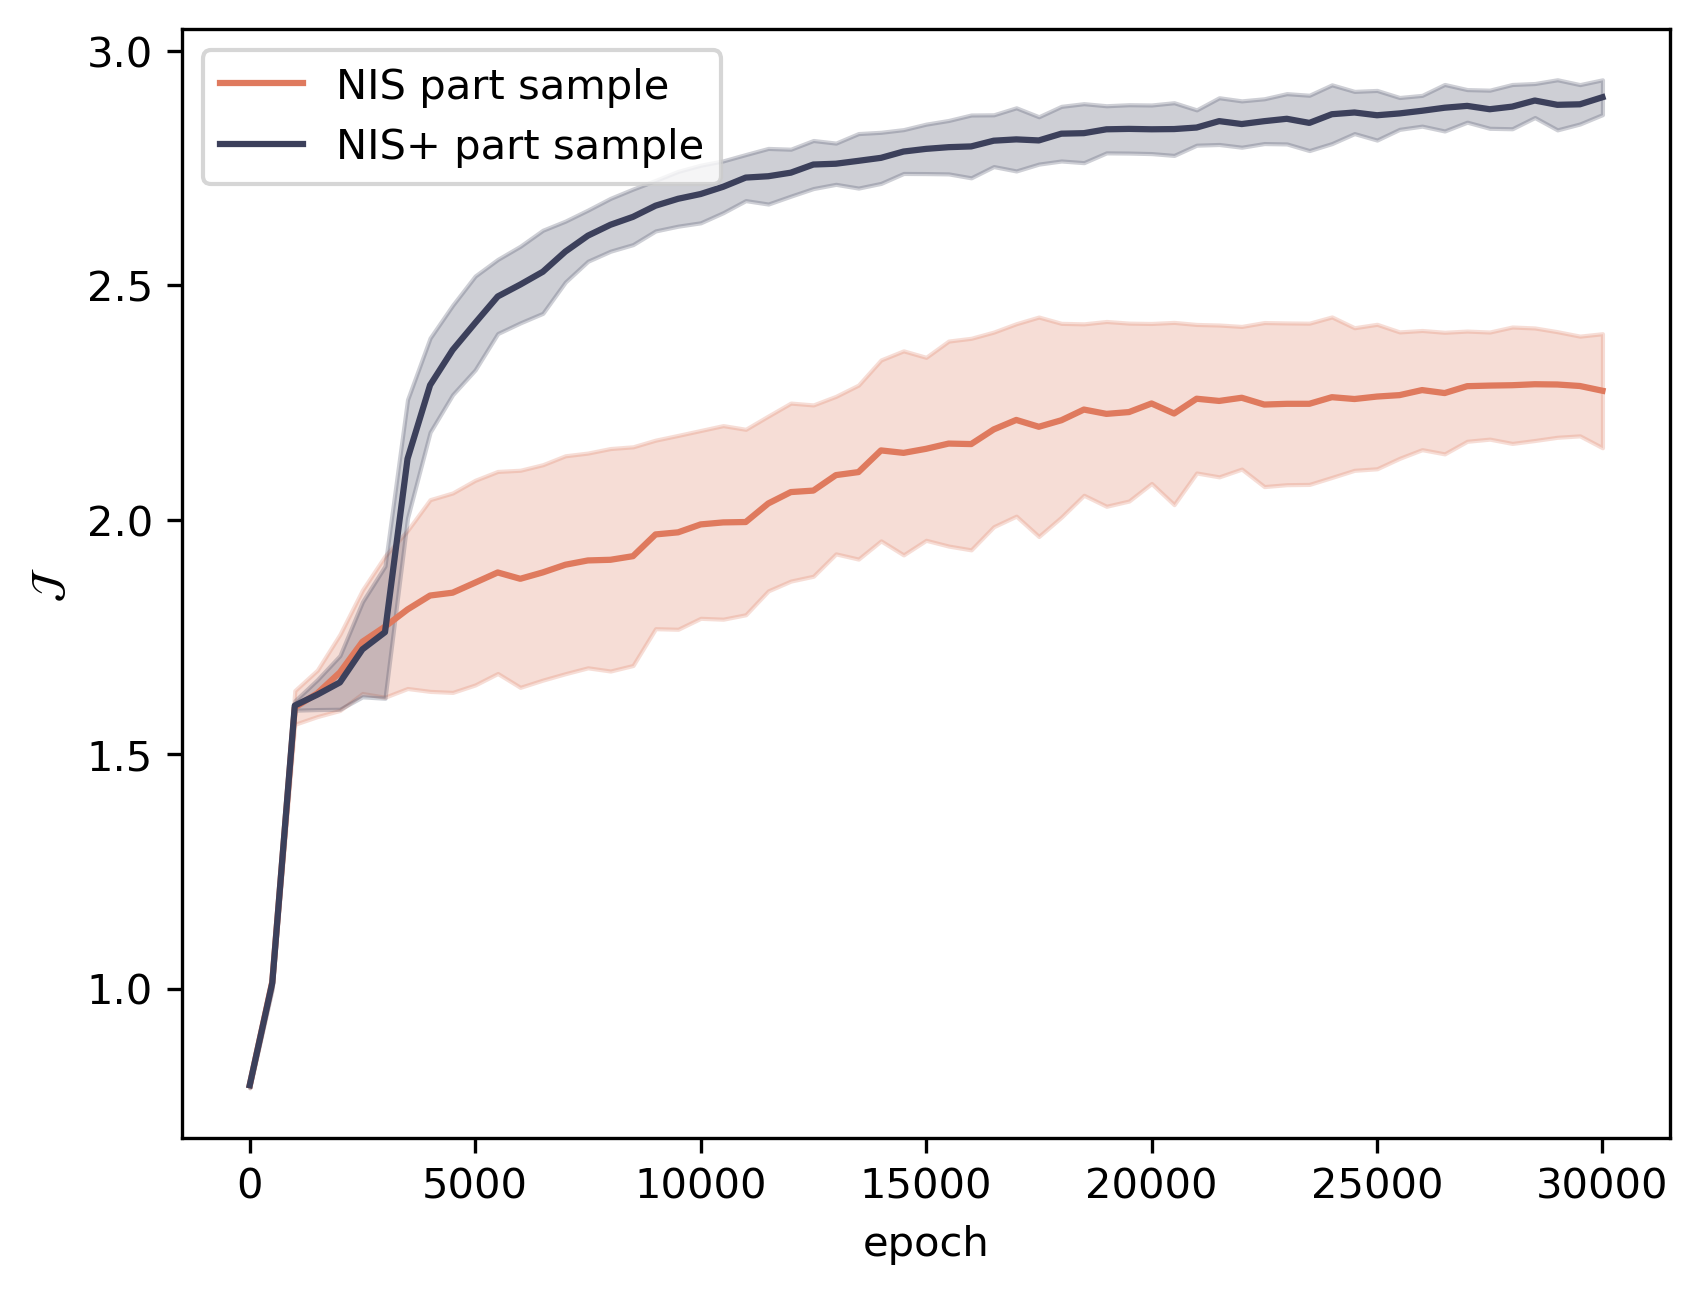

In [12]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_nis))*500
means_nis = np.mean(eis_nis_e,axis=0)
stds_nis = np.std(eis_nis_e,axis=0)
means_nisp = np.mean(eis_nisp_e,axis=0)
stds_nisp = np.std(eis_nisp_e,axis=0)
plt.plot(timesteps, means_nis, label='NIS part sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel(r'$\mathcal{J}$')
plt.show()

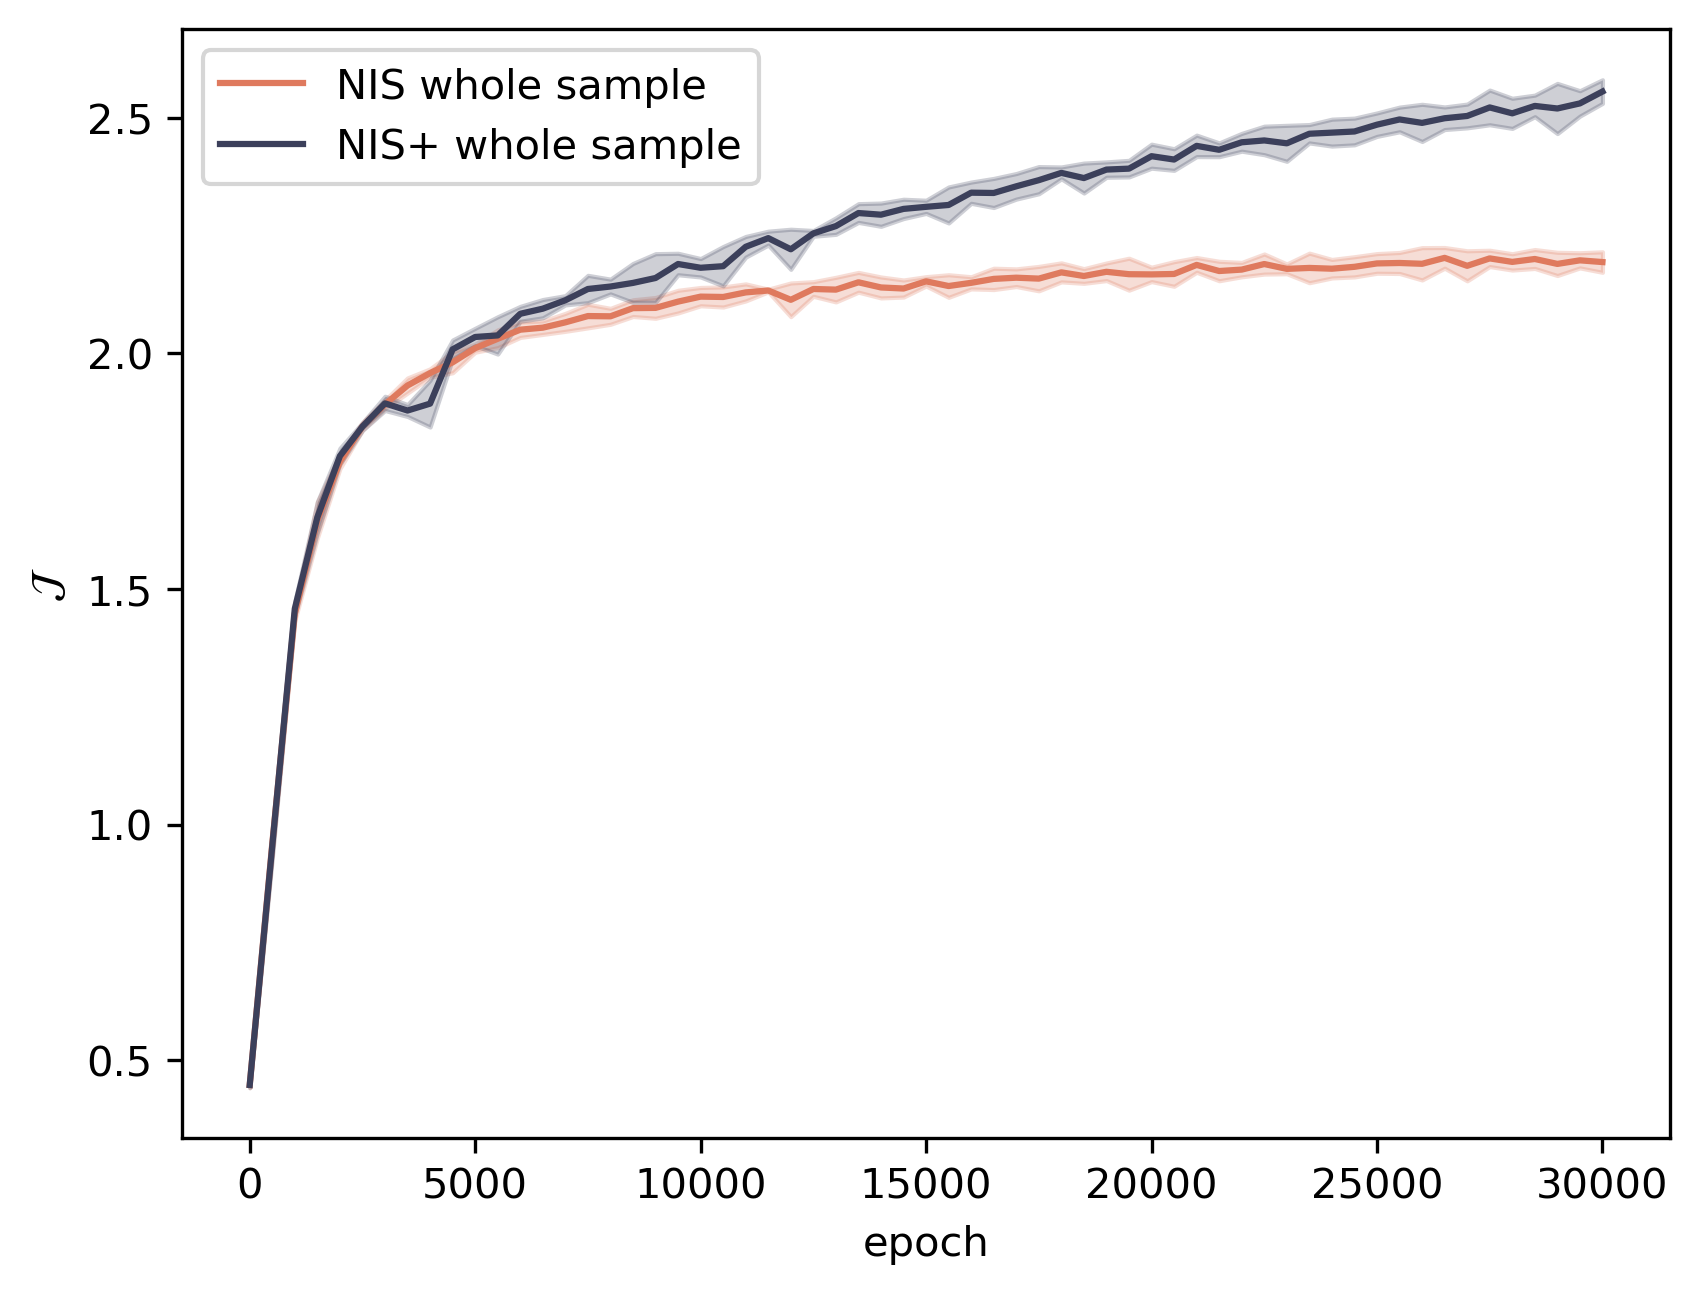

In [7]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_nis))*500
means_nis = np.mean(eis_nis_e,axis=0)
stds_nis = np.std(eis_nis_e,axis=0)
means_nisp = np.mean(eis_nisp_e,axis=0)
stds_nisp = np.std(eis_nisp_e,axis=0)
plt.plot(timesteps, means_nis, label='NIS whole sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='NIS+ whole sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel(r'$\mathcal{J}$')
plt.show()